# Tim Allen: Design and Research Craftsman

### "What’s the least amount of fidelity you can give to an idea that allows people to understand that it’s a great idea?" —via [Finding Our Way](https://findingourway.design/2023/04/12/38-the-craft-led-design-executive-ft-tim-allen/)

### We think across the food, cooking, and groceries space with the Tim Allen

Instructions for getting cozy with this AI recipe are on the [GitHub page's README](https://aka.ms/CAIK-repo). 

# 🧑‍🍳 Recipe for AI-driven 

- ~500 tokens from COMPLETION Pre-trained Foundation Model
- borrow a little multi-modal AI model energy from GPT-4V

> [!IMPORTANT]
> You will need an [.Net 7 SDK](https://dotnet.microsoft.com/en-us/download) and [Polyglot](https://marketplace.visualstudio.com/items?itemName=ms-dotnettools.dotnet-interactive-vscode) to get started with this notebook using .Net Interactive

# Gather the core tools 🧰

When running the following cell, if asked to "select your kernel" (note this will be referring to the Jupyter notebook's kernel and not Semantic Kernel) then choose `.NET Interactive` from the available menu options.

In [1]:
#r "nuget: Microsoft.SemanticKernel, 1.1.0"
#r "nuget: Microsoft.SemanticKernel.Plugins.Core, 1.1.0-alpha"
#r "nuget: Microsoft.Extensions.Logging.Console, 8.0.0"
#r "nuget: System.Linq.Async, 6.0.1"
#r "nuget: Microsoft.SemanticKernel.Plugins.Memory, 1.1.0-alpha"
#r "nuget: Microsoft.SemanticKernel.Connectors.Chroma, 1.1.0-alpha"

Installed Packages Microsoft.Extensions.Logging.Console, 8.0.0 Microsoft.SemanticKernel, 1.1.0 Microsoft.SemanticKernel.Connectors.Chroma, 1.1.0-alpha Microsoft.SemanticKernel.Plugins.Core, 1.1.0-alpha Microsoft.SemanticKernel.Plugins.Memory, 1.1.0-alpha System.Linq.Async, 6.0.1

In [2]:
// Load settings
#!import ../config/Settings.cs 

var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();

# Fire up a kernel with TWO models 🔥

In [3]:
using System;
using System.ComponentModel;
using System.Threading.Tasks;
using Microsoft.SemanticKernel.Memory;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using Kernel = Microsoft.SemanticKernel.Kernel;

// Memory functionality is experimental
#pragma warning disable SKEXP0003, SKEXP0011, SKEXP0052

Kernel kernel;

var memoryBuilder = new MemoryBuilder();

if (useAzureOpenAI)
{
    memoryBuilder.WithAzureOpenAITextEmbeddingGeneration(
        "text-embedding-ada-002",
        azureEndpoint, 
        apiKey,
        "model-id");
    kernel = Kernel.CreateBuilder()
        .AddAzureOpenAIChatCompletion(model, azureEndpoint, apiKey)
        .Build();
} else {
    memoryBuilder.WithOpenAITextEmbeddingGeneration("text-embedding-ada-002", apiKey);
    kernel = Kernel.CreateBuilder()
        .AddOpenAIChatCompletion(model, apiKey, orgId)
        .Build();
}

memoryBuilder.WithMemoryStore(new VolatileMemoryStore());

var memory = memoryBuilder.Build();

## A 👁️ multi-modal model might be fun to add to the mix

![](imgs/grocer.jpg)

Let's use a photo I shot at my nearby supermarket, and ask GPT-4V what's in the image.

![](imgs/grocergpt4v.png)

General access to GPT-4V isn't available by API yet, so we're just simulating it here.

In [4]:
var vizResult = @"
* Asparagus 
* Artichokes 
* Eggplants
* Yellow squashes
* Zucchinis
* Butternut squashes 
* Green beans
";

# Generate embeddings for later 🧲 gathering

In [5]:
const string MemoryCollectionName = "preferences";

string[] notes = { 
    "for breakfast, meals with eggs are preferred and low salt",
    "for lunch, a meal with less than 300 calories is best",
    "for dinner, definitely offer dessert"
};

for (int i = 0; i < notes.Length; i++)
{
    await memory.SaveInformationAsync(MemoryCollectionName, id: $"note{i}", text: notes[i]);
}

# You can always 🤔 look up what your visitor prefers

In [6]:
var q = "breakfast";

var response = await memory.SearchAsync(MemoryCollectionName, q).FirstOrDefaultAsync();
var mealPreference = response?.Metadata.Text;
Console.WriteLine($"{q}\n> {mealPreference}");

breakfast
> for breakfast, meals with eggs are preferred and low salt


## Now we have enough information to get 🧑‍🍳 cooking

Let's add the inventory of what's in my fridge (that we could get from a 🔌 Plugin) to what we know about our world. And let's use the image snapshot of what we can get at our local grocer.

In [7]:
var inMyFridgeAndPantry = @"
milk, eggs, butter, chicken, cheese, yogurt, salt, pepper, sugar, olive oil, flour
";

Console.WriteLine($"Meal preference: {mealPreference}\n");
Console.WriteLine($"In my fridge and pantry:\n{inMyFridgeAndPantry}");
Console.WriteLine($"Available at my grocer: {vizResult}");

Meal preference: for breakfast, meals with eggs are preferred and low salt

In my fridge and pantry:

milk, eggs, butter, chicken, cheese, yogurt, salt, pepper, sugar, olive oil, flour

Available at my grocer: 
* Asparagus 
* Artichokes 
* Eggplants
* Yellow squashes
* Zucchinis
* Butternut squashes 
* Green beans



## Let's 🤔 determine what to make ...

In [8]:
using Microsoft.SemanticKernel.Connectors.OpenAI;

var pluginsSKDirectory =  Path.Combine(System.IO.Directory.GetCurrentDirectory(), "plugins");

var myFunctions = kernel.ImportPluginFromPromptDirectory(Path.Combine(pluginsSKDirectory, "CookingForReal"));

KernelArguments args = new(
    new OpenAIPromptExecutionSettings { MaxTokens = 500, Temperature = 0.5 }) { 
    { "grocer",  vizResult},
    {"available", inMyFridgeAndPantry},
    {"mealtype", mealPreference}};

var myResult = await kernel.InvokeAsync(myFunctions["MealSuggester"], args);
var mealString = myResult.ToString();

Console.WriteLine(mealString);

For breakfast, we will make a delicious and healthy vegetable omelette. We will use eggs, milk, and a variety of vegetables such as asparagus, artichokes, and zucchinis. We will season it with pepper and a small amount of salt for flavor.


## Let's go 🛒 shopping 

In [11]:
KernelArguments args = new(
    new OpenAIPromptExecutionSettings { MaxTokens = 500, Temperature = 0.5 }) { 
    { "grocer",  vizResult},
    {"available", inMyFridgeAndPantry},
    {"themeal", mealString}}; 

var myResult = await kernel.InvokeAsync(myFunctions["ShoppingSuggester"], args);
var resultString = myResult.GetValue<string>();

Console.WriteLine(resultString);

To make the vegetable omelette, the following items should be picked up at the grocer:

- Asparagus
- Artichokes
- Zucchinis


# Plate the partially finished meal 🍽️

Let's ready an image generation model ...

In [13]:
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.TextToImage;
using Microsoft.SemanticKernel.Embeddings;
using Microsoft.SemanticKernel.Connectors.OpenAI;

using Kernel = Microsoft.SemanticKernel.Kernel;

#pragma warning disable SKEXP0001, SKEXP0002, SKEXP0011, SKEXP0012

var builder = Kernel.CreateBuilder();

if(useAzureOpenAI)
{
    builder.AddAzureOpenAIChatCompletion(model, azureEndpoint, apiKey);
    builder.AddAzureOpenAITextToImage("dall-e-3",azureEndpoint, apiKey);
}
else
{
    builder.AddOpenAIChatCompletion(model, apiKey, orgId);
    builder.AddOpenAITextToImage(apiKey, orgId);
}
   
var kernel = builder.Build();

// Get AI service instance used to generate images
var dallE = kernel.GetRequiredService<ITextToImageService>();

And let's render that meal we were talking about ...

In [20]:
#!import ../config/SkiaUtils.cs

using System;
using System.Threading.Tasks;
using Microsoft.Extensions.Configuration;
using System.IO;
using System.Net.Http;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using Microsoft.SemanticKernel.TextToImage;
using Microsoft.SemanticKernel.Embeddings;

#pragma warning disable SKEXP0002

HttpClient httpClient = new HttpClient();

async Task DownloadImageAsync(string uri, string localPath)
{
    using (HttpResponseMessage response = await httpClient.GetAsync(uri))
    {
        response.EnsureSuccessStatusCode();

        using (Stream contentStream = await response.Content.ReadAsStreamAsync(), 
                fileStream = new FileStream(localPath, FileMode.Create, FileAccess.Write, FileShare.None))
        {
            await contentStream.CopyToAsync(fileStream);
        }
    }
}

KernelArguments args = new(
    new OpenAIPromptExecutionSettings { MaxTokens = 500, Temperature = 0.5 }) { 
    { "mealdescription",  mealString}}; 

var myResult = await kernel.InvokeAsync(myFunctions["PlatingAssistant"], args);
var dalleString = myResult.ToString();

Console.WriteLine(dalleString);

var imageDescription = dalleString;
var image = await dallE.GenerateImageAsync(imageDescription.Trim(), 512, 512);

Console.WriteLine(imageDescription);
Console.WriteLine("Image URL: " + image);
string uniqueFileName = "abc-" + Guid.NewGuid().ToString() + ".png";
Console.WriteLine(uniqueFileName);
await DownloadImageAsync(image,uniqueFileName);

"Please generate an image of a vegetable omelette made with eggs, milk, asparagus, artichokes, and zucchinis. The omelette should be seasoned with pepper and a small amount of salt."
"Please generate an image of a vegetable omelette made with eggs, milk, asparagus, artichokes, and zucchinis. The omelette should be seasoned with pepper and a small amount of salt."
Image URL: https://oaidalleapiprodscus.blob.core.windows.net/private/org-rocrupyvzgcl4yf25rqq6d1v/user-llcMA8baSvN14XBWssakSbKG/img-4nXpwbdqRqnCj7EZ5pmRXKt9.png?st=2024-01-23T20%3A10%3A01Z&se=2024-01-23T22%3A10%3A01Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2024-01-23T19%3A38%3A47Z&ske=2024-01-24T19%3A38%3A47Z&sks=b&skv=2021-08-06&sig=RUMuL/vOOAskeb0YQNOqL5lYHFkTAvekR7APh4wtCnw%3D
abc-25916ffe-22da-4921-9531-aa4aa643476c.png


You can look at it inline too:


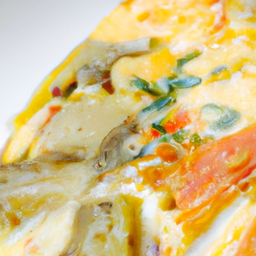

In [21]:
await SkiaUtils.ShowImage(image, 256, 256);